In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data_dir = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/models/grid_analysis/human'

In [419]:
model_name_transformer = {
    'bonito': 'Bonito',
    'catcaller': 'CATCaller',
    'sacall': 'SACall',
    'urnano': 'URNano',
    'mincall': 'MinCall',
    'halcyon': 'Halcyon',
    'causalcall': 'Causalcall',
    'halcyonmod': 'HalcyonMod',
    'bonitofwd': 'BonitoFwd',
    'bonitorev': 'BonitoRev',
    'catcaller': 'CATCaller',
    'sacall': 'SACall',
    'urnano': 'URNano',
    'lstm1': 'LSTM1',
    'lstm3': 'LSTM3',
    'lstm5': 'LSTM5'
}

metric_name_transformer = {
    'match_rate': 'Match rate',
    'mismatch_rate': 'Mismatch rate',
    'deletion_rate': 'Deletion rate',
    'insertion_rate': 'Insertion rate',
    'phred_mean_correct': 'PhredQ Mean Correct',
    'phred_mean_error': 'PhredQ Mean Error',
    'phred_error_test': 'PhredQ Correct vs Error Test (p-value)',
    'phred_mean_correct_error_ratio': 'PhredQ Correct/Error',
    'total_homo_error_rate' : 'Homopolymer Total Error Rate',
    'A_homo_error_rate' : 'Homopolymer A Error Rate', 
    'C_homo_error_rate' : 'Homopolymer C Error Rate', 
    'G_homo_error_rate' : 'Homopolymer G Error Rate', 
    'T_homo_error_rate' : 'Homopolymer T Error Rate',
    'total_divergence': 'Total Divergence',
    'A_divergence': 'A Divergence',
    'C_divergence': 'C Divergence',
    'G_divergence': 'G Divergence',
    'T_divergence': 'T Divergence'
}

def transform_name(name):

    name_components = name.split('_')
    new_name = ''
    new_name += model_name_transformer[name_components[0]]
    new_name += ' - '
    new_name += model_name_transformer[name_components[1]]

    return new_name

In [3]:
evaluation_dfs = list()
for model_dir in os.listdir(data_dir):
    try:
        df = pd.read_csv(os.path.join(data_dir, model_dir, 'basecalls_1_0.1_evaluation.csv'), header=0, index_col=False)
        config = model_dir.split('_')
        df['model'] = model_dir
        df['cnn'] = config[0]
        df['encoder'] = config[1]
        df['decoder'] = config[2]
        evaluation_dfs.append(df)
    except FileNotFoundError:
        continue
df = pd.concat(evaluation_dfs)
df = df.sort_values('model')
df = df.reset_index()

# Number of successfully evaluated reads

In [4]:
plot_df = {
    'model': list(),
    'counts': list(),
    'reason': list()
}

for model in set(df['model']):
    st = df['model'].searchsorted(model, 'left')
    nd = df['model'].searchsorted(model, 'right')

    subdf = df[st:nd]
    counts = subdf["comment"].value_counts(normalize = True)
    for k in counts.keys():
        plot_df['model'].append(model)
        plot_df['counts'].append(counts[k])
        plot_df['reason'].append(k)
plot_df = pd.DataFrame(plot_df)    

<AxesSubplot:xlabel='counts', ylabel='model'>

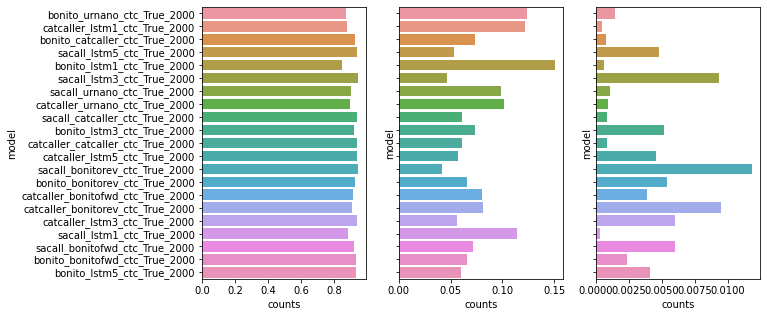

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
sns.barplot(x = 'counts', y = 'model', data = plot_df[plot_df['reason'] == 'pass'], orient='h', ax = ax1)
sns.barplot(x = 'counts', y = 'model', data = plot_df[plot_df['reason'] == 'failed mapping'], orient='h', ax = ax2)
sns.barplot(x = 'counts', y = 'model', data = plot_df[plot_df['reason'] == 'no prediction'], orient='h', ax = ax3)

# Rates

In [6]:
# calculate rates

# match rate
BASES = ['A', 'C', 'G', 'T']
match_columns = list()
mismatch_columns = list()
insertion_columns = list()
deletion_columns = list()
for b1 in BASES:
    for b2 in BASES + ['-']:
        for b3 in BASES + ['-']:
            for b4 in BASES:
                if b2 == '-' and b3 == '-':
                    continue
                if b2 == b3:
                    match_columns.append(b1 + b2 + '>' + b3 + b4)
                else:
                    if b2 == '-':
                        deletion_columns.append(b1 + b2 + '>' + b3 + b4)
                    elif b3 == '-':
                        insertion_columns.append(b1 + b2 + '>' + b3 + b4)
                    else:
                        mismatch_columns.append(b1 + b2 + '>' + b3 + b4)

In [7]:
df['match_rate'] = df[match_columns].sum(axis=1)/df['len_basecalls']
df['mismatch_rate'] = df[mismatch_columns].sum(axis=1)/df['len_basecalls']
df['insertion_rate'] = df[insertion_columns].sum(axis=1)/df['len_basecalls']
df['deletion_rate'] = df[deletion_columns].sum(axis=1)/df['len_basecalls']

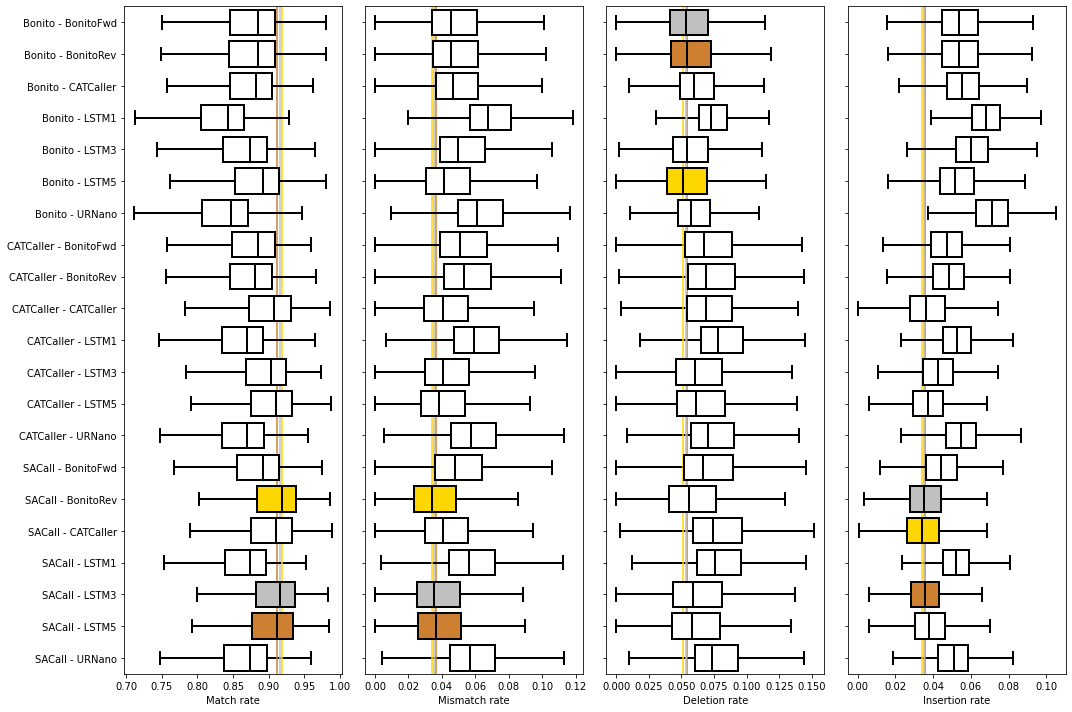

In [118]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10), sharey=True)

axes = [ax1, ax2, ax3, ax4]
metrics = ['match_rate', 'mismatch_rate', 'deletion_rate', 'insertion_rate']
for ax, metric in zip(axes, metrics):

    model_name_sorted = np.unique(df['model'])[::-1]
    medians = list()
    for i, model_name in enumerate(model_name_sorted):
        plot_df = df[df['model'] == model_name]
        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]
        
        medians.append(np.median(x))
    medians = np.array(medians)

    if metric == 'match_rate':
        top_3_models = model_name_sorted[np.argsort(medians)[-3:]]
        medal_colors = ['#CD7F32', '#C0C0C0', '#FFD700'] # bronze, silver, gold
    else:
        top_3_models = model_name_sorted[np.argsort(medians)[:3]]
        medal_colors = ['#FFD700', '#C0C0C0', '#CD7F32'] # gold, silver, bronze 

    ticks_names = list()
    for i, model_name in enumerate(model_name_sorted):

        plot_df = df[df['model'] == model_name]
        ticks_names.append(transform_name(model_name))

        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]

        if model_name in top_3_models:
            color = medal_colors[int(np.where(top_3_models == model_name)[0])]
            ax.axvline(np.median(x), color = color)
        else:
            color = 'white'
        
        bp = ax.boxplot(x, positions = [i + 1], showfliers=False, widths = [0.8], vert = False, patch_artist = True)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black',  linewidth=2)
        plt.setp(bp['boxes'], facecolor = color)

    ax.set_xlabel(metric_name_transformer[metric])


ax1.set_yticks(ticks = np.arange(1, len(set(df['model'])) + 1, 1))
ax1.set_yticklabels(labels = ticks_names)
plt.tight_layout()
plt.show()

# PhredQ

In [137]:
df['phred_mean_correct_error_ratio'] = df['phred_mean_correct']/df['phred_mean_error']

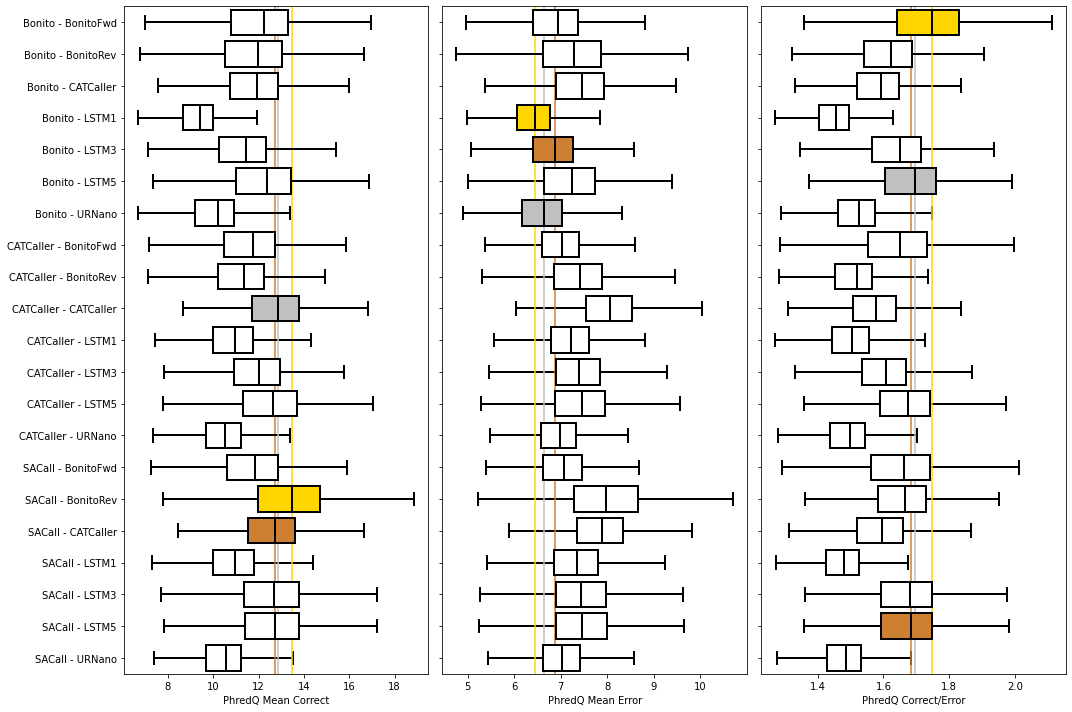

In [140]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10), sharey=True)

axes = [ax1, ax2, ax3]
metrics = ['phred_mean_correct', 'phred_mean_error', 'phred_mean_correct_error_ratio']
for ax, metric in zip(axes, metrics):

    model_name_sorted = np.unique(df['model'])[::-1]
    medians = list()
    for i, model_name in enumerate(model_name_sorted):
        plot_df = df[df['model'] == model_name]
        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]
        
        medians.append(np.median(x))
    medians = np.array(medians)

    if metric == 'phred_mean_correct' or metric == 'phred_mean_correct_error_ratio':
        top_3_models = model_name_sorted[np.argsort(medians)[-3:]]
        medal_colors = ['#CD7F32', '#C0C0C0', '#FFD700'] # bronze, silver, gold
    else:
        top_3_models = model_name_sorted[np.argsort(medians)[:3]]
        medal_colors = ['#FFD700', '#C0C0C0', '#CD7F32'] # gold, silver, bronze 

    ticks_names = list()
    for i, model_name in enumerate(model_name_sorted):

        plot_df = df[df['model'] == model_name]
        ticks_names.append(transform_name(model_name))

        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]

        if model_name in top_3_models:
            color = medal_colors[int(np.where(top_3_models == model_name)[0])]
            ax.axvline(np.median(x), color = color)
        else:
            color = 'white'
        
        bp = ax.boxplot(x, positions = [i + 1], showfliers=False, widths = [0.8], vert = False, patch_artist = True)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black',  linewidth=2)
        plt.setp(bp['boxes'], facecolor = color)

    ax.set_xlabel(metric_name_transformer[metric])


ax1.set_yticks(ticks = np.arange(1, len(set(df['model'])) + 1, 1))
ax1.set_yticklabels(labels = ticks_names)
plt.tight_layout()
plt.show()

# Randomness

In [349]:
ERRORS = list()
for b1 in BASES:
    for b2 in BASES + ['-']:
        for b3 in BASES + ['-']:
            for b4 in BASES:
                if b2 == '-' and b3 == '-':
                    continue
                ERRORS.append(b1 + b2 + '>' + b3 + b4)

In [359]:
model_name = 'sacall_bonitorev_ctc_True_2000'

model_df = df[df['model'] == model_name]

In [380]:
def calculate_signatures(model_df):
    bases = ["A", "C", "G", "T"]
    types = ["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Missmatch", "Insertion", "Deletion"]
    signature_columns = model_df.columns[model_df.columns.str.contains('>')]

    signatures = list()
    for b in bases:
        for b1 in bases:
            for b2 in bases:
                for t in types:
                    signatures.append({'Base': b, 'Context': b1+b+b2, 'Error': t, "Count": 0, "Rate": 0.0, "k": b+b1+b2+t})
    signatures_df = pd.DataFrame(signatures)

    for s_col in signature_columns:
        k1 = s_col[1] if s_col[1] != '-' else s_col[3]
        k2 = s_col[0] + s_col[-1]
        if s_col[1] == '-':
            k3 = "Insertion"
        elif s_col[3] == '-':
            k3 = "Deletion"
        elif s_col[1] == s_col[3]:
            k3 = "Match"
        else:
            k3 = "Missmatch"
        p = np.where(signatures_df["k"] == k1+k2+k3)[0]
        signatures_df.iloc[p, 3] += np.sum(model_df[s_col])
        if k3 == 'Missmatch':
            k3 = "Missmatch_" + s_col[3]
            p = np.where(signatures_df["k"] == k1+k2+k3)[0]
            signatures_df.iloc[p, 3] += np.sum(model_df[s_col])

    for b in np.unique(signatures_df["Base"]):
        sub_df = signatures_df[signatures_df["Base"] == b]
        for c in np.unique(signatures_df["Context"]):
            subsub_df = sub_df[sub_df["Context"] == c]
            subsub_df = subsub_df[subsub_df["Error"].isin(["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion", 'Insertion'])]
            t = np.sum(subsub_df["Count"])
            signatures_df.loc[subsub_df.index, 'Rate'] = signatures_df.loc[subsub_df.index, 'Count']/t

    d_list = list()
    for b in np.unique(signatures_df["Base"]):
        sub_df = signatures_df[signatures_df["Base"] == b]
        sub_df = sub_df[sub_df["Error"].isin(["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion", 'Insertion'])]
        total_bases = np.sum(sub_df['Count'])
        for c in np.unique(signatures_df["Error"]):
            subsub_df = sub_df[sub_df["Error"] == c]
            total_errors = np.sum(subsub_df['Count'])
            d = {'Base': 'Grouped', 'Context': 'N'+b+'N', 'Error': c, 'Count': total_errors, 'Rate':total_errors/total_bases, 'k': b+c}
            d_list.append(d)

    total_bases = np.sum(signatures_df['Count'])
    for c in np.unique(signatures_df["Error"]):
        sub_df = signatures_df[signatures_df["Error"] == c]
        total_errors = np.sum(sub_df['Count'])
        d = {'Base': 'Grouped', 'Context': 'NNN', 'Error': c, 'Count': total_errors, 'Rate':total_errors/total_bases, 'k': b+c}
        d_list.append(d)

    signatures_df = signatures_df.append(pd.DataFrame(d_list))
    return signatures_df



## Signatures plot

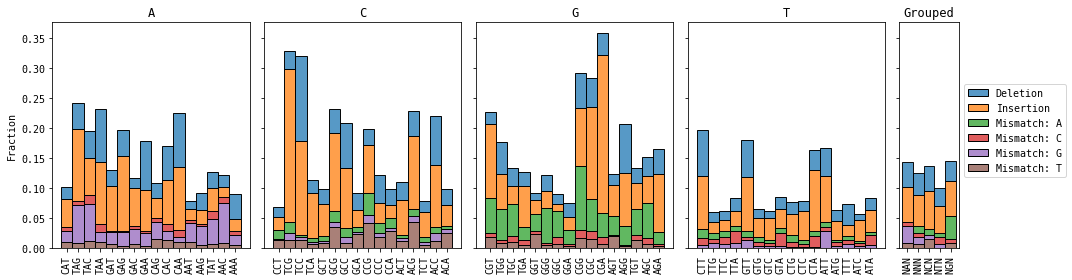

In [381]:
signatures_df = calculate_signatures(model_df)

plt.rcParams["font.family"] = "monospace"

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.3]})
for i, b in enumerate(bases + ['Grouped']):
    plot_df = signatures_df[signatures_df["Base"] == b]
    plot_df = plot_df[plot_df["Error"].isin(["Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion", "Insertion"])]
    plot_df = plot_df.sort_values('Error')
    sns.histplot(x = "Context", hue = "Error", weights='Rate', data = plot_df, 
                 multiple='stack', ax = axs[i])
    axs[i].set_ylabel('Fraction')
    axs[i].set_xlabel(None)
    axs[i].set_title(b)
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)
    if i != 4:
        axs[i].get_legend().remove()
    else:
        legend = axs[i].get_legend()
        legend.set_title(None)
        legend.texts[0].set_text("Deletion")
        legend.texts[1].set_text("Insertion")
        legend.texts[2].set_text("Mismatch: A")
        legend.texts[3].set_text("Mismatch: C")
        legend.texts[4].set_text("Mismatch: G")
        legend.texts[5].set_text("Mismatch: T")
        legend.set_bbox_to_anchor((1, 0.75))
        

fig.tight_layout()


## Randomness

In [415]:
from scipy.spatial.distance import jensenshannon


randomness_df = {
    'model': list(),
    'divergence': list(),
    'base': list()
}

for model_name in np.unique(df['model']):

    signatures_df = calculate_signatures(df[df['model'] == model_name])

    signatures_df = signatures_df.sort_values(['Base', 'Context', 'Error'])
    groups = ['NAN', 'NCN', 'NGN', 'NTN']
    for group in groups:
        subdf = signatures_df[signatures_df['Context'] == group]
        subdf = subdf[subdf['Error'] != 'Missmatch']
        avg_rates = np.array(subdf['Rate'])

        base = list(group)[1]
        subdf = signatures_df[signatures_df['Base'] == base]
        subdf = subdf[subdf['Error'] != 'Missmatch']

        for context in np.unique(sub_df['Context']):
            subsubdf = subdf[subdf['Context'] == context]
            rates = np.array(subsubdf['Rate'])

            if len(rates) == 0:
                continue

            randomness_df['model'].append(model_name)
            randomness_df['base'].append(base + '_divergence')
            randomness_df['divergence'].append(jensenshannon(avg_rates, rates) ** 2)
            
            randomness_df['model'].append(model_name)
            randomness_df['base'].append('total_divergence')
            randomness_df['divergence'].append(jensenshannon(avg_rates, rates) ** 2)
            
randomness_df = pd.DataFrame(randomness_df)

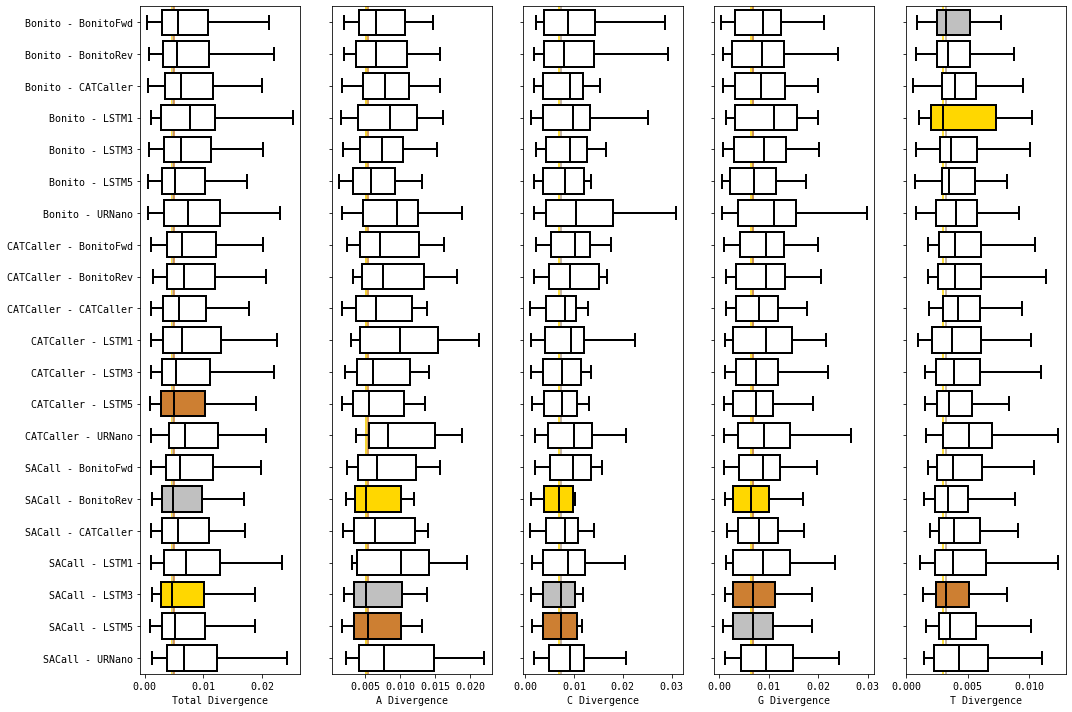

In [420]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

axes = [ax1, ax2, ax3, ax4, ax5]
metrics = ['total_divergence', 'A_divergence', 'C_divergence', 'G_divergence', 'T_divergence']
for ax, metric in zip(axes, metrics):

    model_name_sorted = np.unique(randomness_df['model'])[::-1]
    medians = list()
    for i, model_name in enumerate(model_name_sorted):
        plot_df = randomness_df[randomness_df['model'] == model_name]
        x = np.array(plot_df.loc[plot_df['base'] == metric, 'divergence'])
        x = x[~np.isnan(x)]
        
        medians.append(np.median(x))
    medians = np.array(medians)

    top_3_models = model_name_sorted[np.argsort(medians)[:3]]
    medal_colors = ['#FFD700', '#C0C0C0', '#CD7F32'] # gold, silver, bronze 

    ticks_names = list()
    for i, model_name in enumerate(model_name_sorted):

        plot_df = randomness_df[randomness_df['model'] == model_name]
        x = np.array(plot_df.loc[plot_df['base'] == metric, 'divergence'])
        x = x[~np.isnan(x)]
        ticks_names.append(transform_name(model_name))

        if model_name in top_3_models:
            color = medal_colors[int(np.where(top_3_models == model_name)[0])]
            ax.axvline(np.median(x), color = color)
        else:
            color = 'white'
        
        bp = ax.boxplot(x, positions = [i + 1], showfliers=False, widths = [0.8], vert = False, patch_artist = True)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black',  linewidth=2)
        plt.setp(bp['boxes'], facecolor = color)

    ax.set_xlabel(metric_name_transformer[metric])


ax1.set_yticks(ticks = np.arange(1, len(set(df['model'])) + 1, 1))
ax1.set_yticklabels(labels = ticks_names)
plt.tight_layout()
plt.show()

## Signature correlation

In [440]:
signatures = list()
for model_name in np.unique(df['model']):

    signatures_df = calculate_signatures(df[df['model'] == model_name])
    signatures_df = signatures_df.sort_values(['Base', 'Context', 'Error'])
    signatures_df = signatures_df[signatures_df["Error"].isin(["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion", 'Insertion'])]
    signatures_df = signatures_df[signatures_df['Base'] != 'Grouped']
    signature = np.array(signatures_df['Rate'])
    signatures.append(signature)
signatures = np.vstack(signatures)

In [468]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [488]:
model_names = list()

for mn in np.unique(df['model']):
    model_names.append(transform_name(mn))
model_names = np.array(model_names)


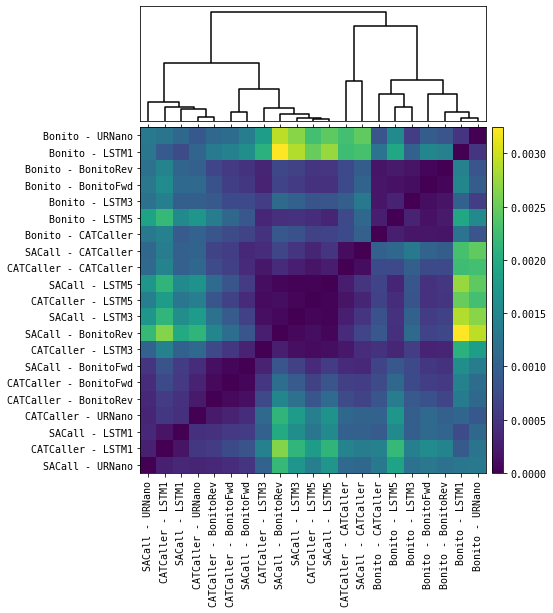

In [492]:
D = pairwise_distances(X = signatures, metric = 'cosine')
condensedD = squareform(D)

# Compute and plot first dendrogram.
fig = plt.figure(figsize=(8,8))

ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Y = sch.linkage(condensedD, method='centroid')
link_colors = ["black"] * (2 * len(condensedD) - 1)
Z2 = sch.dendrogram(Y, link_color_func=lambda k: link_colors[k])
ax2.set_xticks([])
ax2.set_yticks([])


# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
D = D[idx2,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.viridis)

axmatrix.set_xticks(np.arange(0, len(np.unique(df['model'])), 1))
axmatrix.set_yticks(np.arange(0, len(np.unique(df['model'])), 1))
axmatrix.set_yticklabels(model_names[idx2])
axmatrix.set_xticklabels(model_names[idx2])
axmatrix.tick_params(labelbottom=True,labeltop=False)
for tick in axmatrix.get_xticklabels():
    tick.set_rotation(90)

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)
fig.show()

# Homopolymers

In [142]:
df['total_homo_counts'] = df['homo_A_counts'] + df['homo_C_counts'] + df['homo_G_counts'] + df['homo_T_counts']
df['total_homo_errors'] = df['homo_A_errors'] + df['homo_C_errors'] + df['homo_G_errors'] + df['homo_T_errors']
df['total_homo_error_rate'] = df['total_homo_errors']/df['total_homo_counts']
df['A_homo_error_rate'] = df['homo_A_errors']/df['homo_A_counts']
df['C_homo_error_rate'] = df['homo_C_errors']/df['homo_C_counts']
df['G_homo_error_rate'] = df['homo_G_errors']/df['homo_G_counts']
df['T_homo_error_rate'] = df['homo_T_errors']/df['homo_T_counts']

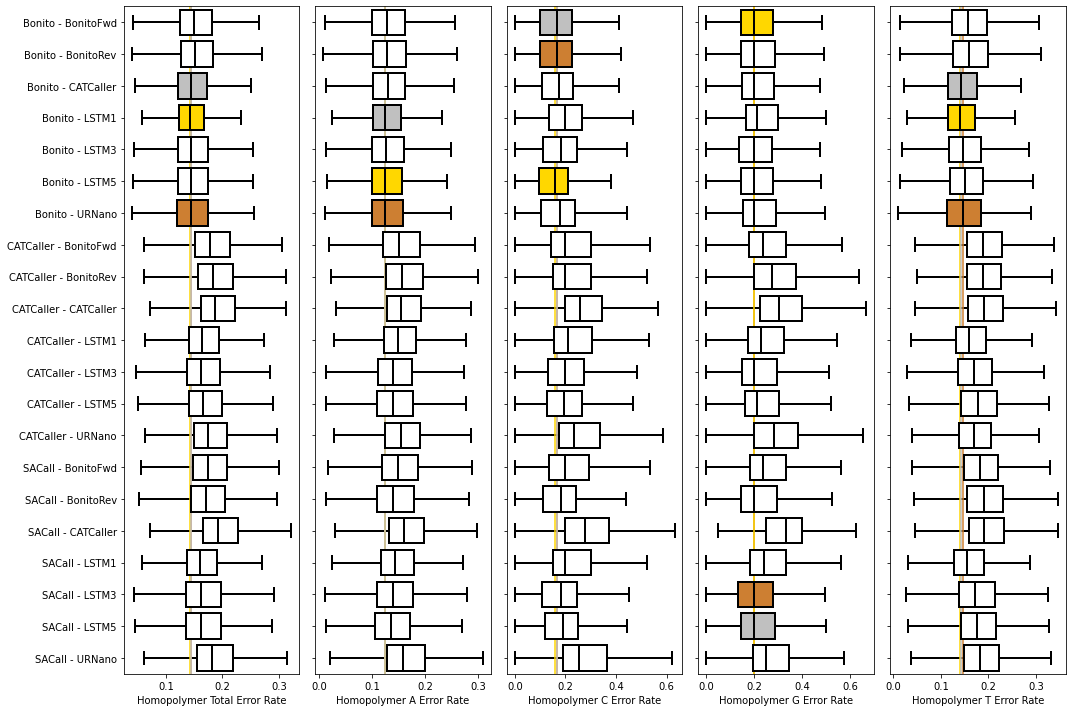

In [143]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

axes = [ax1, ax2, ax3, ax4, ax5]
metrics = ['total_homo_error_rate', 'A_homo_error_rate', 'C_homo_error_rate', 'G_homo_error_rate', 'T_homo_error_rate']
for ax, metric in zip(axes, metrics):

    model_name_sorted = np.unique(df['model'])[::-1]
    medians = list()
    for i, model_name in enumerate(model_name_sorted):
        plot_df = df[df['model'] == model_name]
        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]
        
        medians.append(np.median(x))
    medians = np.array(medians)

    top_3_models = model_name_sorted[np.argsort(medians)[:3]]
    medal_colors = ['#FFD700', '#C0C0C0', '#CD7F32'] # gold, silver, bronze 

    ticks_names = list()
    for i, model_name in enumerate(model_name_sorted):

        plot_df = df[df['model'] == model_name]
        ticks_names.append(transform_name(model_name))

        x = np.array(plot_df[metric])
        x = x[~np.isnan(x)]

        if model_name in top_3_models:
            color = medal_colors[int(np.where(top_3_models == model_name)[0])]
            ax.axvline(np.median(x), color = color)
        else:
            color = 'white'
        
        bp = ax.boxplot(x, positions = [i + 1], showfliers=False, widths = [0.8], vert = False, patch_artist = True)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black',  linewidth=2)
        plt.setp(bp['boxes'], facecolor = color)

    ax.set_xlabel(metric_name_transformer[metric])


ax1.set_yticks(ticks = np.arange(1, len(set(df['model'])) + 1, 1))
ax1.set_yticklabels(labels = ticks_names)
plt.tight_layout()
plt.show()